# GANによる数字画像生成

## TensorFlowのインポート

In [1]:
import tensorflow as tf
tf.__version__

'2.10.0'

## その他のライブラリのインポート

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

## MNISTの読み込み（数字の読み込み）

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# 読み込んだ数字の表示

train_images[0]の数字を変えると別の画像が見られます．

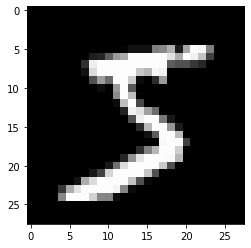

In [4]:
plt.imshow(train_images[0], cmap='gray')

## 画像変換
0～255の画像を-1～1に変換しています．

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

## TensorFlow用データへの変換

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 生成器（generator）のモデルの定義
---



In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

## モデルの生成と初期状態での画像の生成

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## モデルの表示

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

## 分別器（discriminator）のモデルの定義

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## モデルの生成と初期状態で生成した画像の分類

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00372521]], shape=(1, 1), dtype=float32)


## モデルの表示

In [13]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

## 損失関数の設定

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## 分別器（discriminator）の損失関数の設定

In [15]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## 生成器（generator）の損失関数の設定

In [16]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## 生成器と分別器のオプティマイザの設定

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## 再開用ファイルの設定
2行目のコメントアウトを外すとgoogleドライブに保存されます．その際はgoogleドライブをマウントしておく必要があります．

In [18]:
checkpoint_dir = './training_checkpoints'
#checkpoint_dir = '/content/drive/MyDrive/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 変数の設定

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

## 学習の設定

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

## 繰り返し学習の設定

In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

## 画像を保存するための設定

In [22]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 学習開始
1行目のコメントアウトを外すと途中から再開できます．

In [23]:
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
train(train_dataset, EPOCHS)

## gifアニメション作成用処理
#ライブラリのインストール

In [24]:
! pip install imageio

  Obtaining dependency information for imageio from https://files.pythonhosted.org/packages/eb/21/662994d78d8623055f8ffa91838e28f04b2a34bd5d8d6dbc6c7573285ed6/imageio-2.31.3-py3-none-any.whl.metadata
  Obtaining dependency information for pillow>=8.3.2 from https://files.pythonhosted.org/packages/8f/b8/1bf1012eee3059d150194d1fab148f553f3df42cf412e4e6656c772afad9/Pillow-10.0.0-cp39-cp39-win_amd64.whl.metadata
   ---------------------------------------- 313.0/313.0 kB 4.9 MB/s eta 0:00:00
   ---------------------------------------- 2.5/2.5 MB 20.0 MB/s eta 0:00:00


## ライブラリのインポート

In [25]:
import imageio

## gifアニメーションの作成

In [26]:
anim_file = 'dcgan.gif'
#anim_file = '/content/drive/MyDrive/dcgan.gif'#Googleドライブに保存する場合

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

## gifアニメーションの表示用処理（以下，Colab用）

関連プログラムのインストール

In [27]:
! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to c:\users\makino\appdata\local\temp\pip-req-build-cqz0ddvg


  ERROR: Error [WinError 2] 指定されたファイルが見つかりません。 while executing command git version
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


## ライブラリのインポート

In [28]:
import tensorflow_docs.vis.embed as embed

ModuleNotFoundError: No module named 'tensorflow_docs'

## gifアニメーションの表示

In [ ]:
embed.embed_file(anim_file)